# Predicting NVDA Stock Trends with LSTM: 4-Year Historical Analysis

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

We are gonna use the Python's yfinance library to get historic price data for NVIDIA **(NVDA)**. We are gonna be looking at the past 4 years.

In [8]:
news_data = yf.download(
    tickers = 'AAPL',
    start = '2015-01-01',
    end = '2025-01-01',
    interval = '1d',
    auto_adjust = True
).dropna()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [7]:
ticker = yf.Ticker('AAPL')
news_data = ticker.history(period = "10y", interval = "1d").dropna()
news_data

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

We are gonna plot two separate graphs

### High and Low Prices
- Good for volatility/intraday risk

In [ ]:
dates = news_data.index.date
high_prices = news_data['High']
low_prices = news_data['Low']

In [ ]:
plt.figure(figsize = (18, 8)) 
plt.plot(dates, high_prices, label = 'High')
plt.plot(dates, low_prices, label = 'Low')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('High vs. Low Prices (NVDA, 4 Years)')
plt.xlabel('Dates/Time')
plt.ylabel('Prices ($USD)')
plt.legend(fontsize = 16)

plt.gcf().autofmt_xdate()
plt.show()

### Closing and Opening Prices
- Good for overnight sentiment 

In [132]:
dates = news_data.index.date
closing_prices = news_data['Close']
opening_prices = news_data['Open']

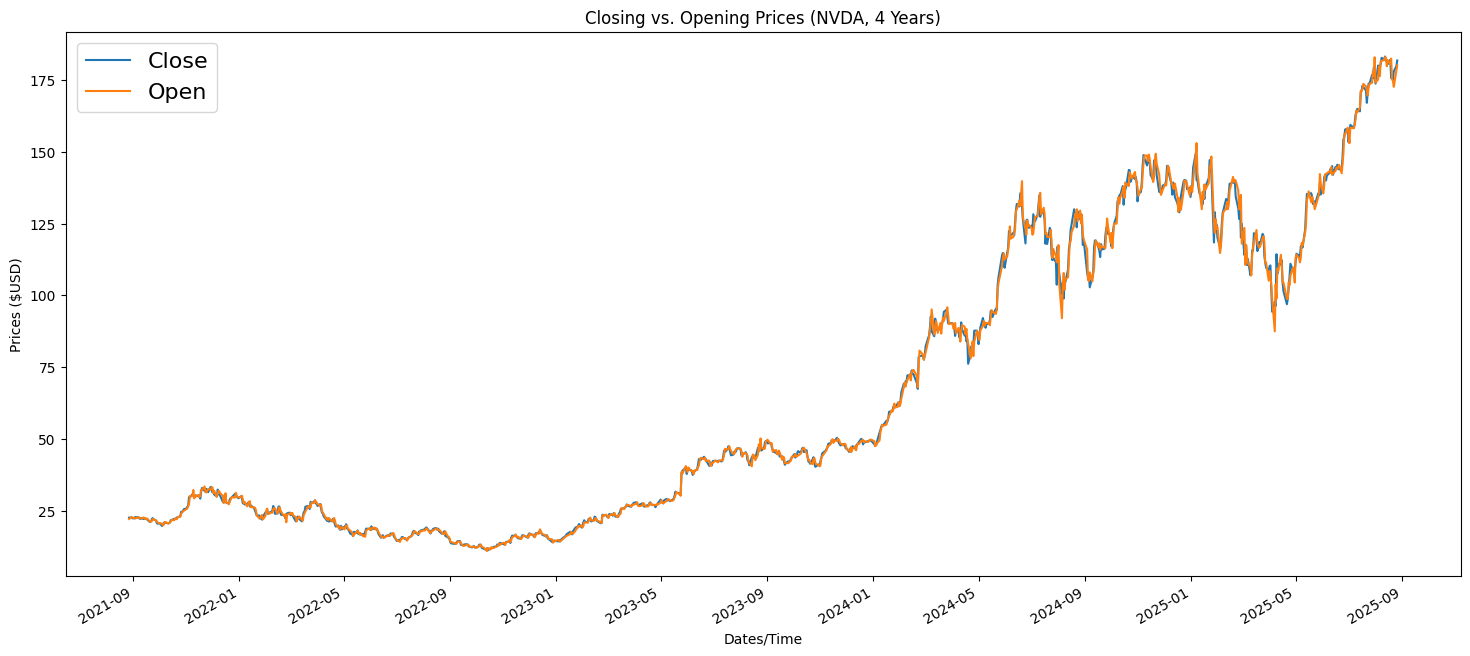

In [134]:
plt.figure(figsize = (18, 8)) 
plt.plot(dates, closing_prices, label = 'Close')
plt.plot(dates, opening_prices, label = 'Open')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('Closing vs. Opening Prices (NVDA, 4 Years)')
plt.xlabel('Dates/Time')
plt.ylabel('Prices ($USD)')
plt.legend(fontsize = 16)

plt.gcf().autofmt_xdate()
plt.show()

## Model for Predicting Closing Prices

- We will be using a training/test split of .80/.20

In [163]:
close_data = news_data[['Close']].values

training_amount = .8
training_index  = int(np.ceil(len(close_data) * training_amount))

window = 90

close_training_data = close_data[0:training_index]
close_test_data = close_data[training_index-window:]

- We are gonna scale the data now using sklearn's **MinMaxScaler()**
- Only gonna transform on test or else the model would use knowledge of the test distribution too (prevent data leakage)

In [165]:
scaler = MinMaxScaler(feature_range = (-1, 1))
training_scaled = scaler.fit_transform(close_training_data.reshape(-1, 1))
testing_scaled = scaler.transform(close_test_data.reshape(-1, 1))

- We will be using a sequence length/window of 90 days
- Below is a function **make_data(X, window)** defined to help create our training/test sets

In [166]:
def make_data(X, window):
    X_output, y_output = [], []
    for i in range(window, len(X)):
        X_output.append(X[i - window:i])
        y_output.append(X[i])
    return np.array(X_output), np.array(y_output)

In [167]:
X_train, y_train = make_data(training_scaled, window)
X_test, y_test = make_data(testing_scaled, window)

In [168]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [169]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [170]:
# to get this run to on gpu
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [171]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 90, 1]) torch.Size([64, 1])


In [158]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.LSTM = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)

        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.LSTM(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# LSTM(input, hidden size, number of stacked layers
# we will use a hidden size of 64
# we will use 2 stacked layers)

model = LSTM(1, 64, 2)
model.to(device)
model

LSTM(
  (LSTM): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [159]:
# we will use a learning rate of .001
# we will be using MSE as a loss function and evaluating with RMSE after 

In [160]:
learning_rate = .001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# remember we made our batch_size = 64

batch_size = 64

In [161]:
def train_epoch():
    model.train()
    print(f'Epoch: {1 + epoch}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print()
    
def validate_epoch():
    model.eval() 
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            
    average_loss_across_batches = running_loss / len(test_loader)
    
    print(f'Validation Loss: {average_loss_across_batches}')
    print('-------------------------------------')
    print()

In [162]:
num_epochs = 50
for epoch in range(num_epochs):
    train_epoch()
    validate_epoch()

Epoch: 1

Validation Loss: 1.7360309064388275
-------------------------------------

Epoch: 2

Validation Loss: 1.020199328660965
-------------------------------------

Epoch: 3

Validation Loss: 0.23847656976431608
-------------------------------------

Epoch: 4

Validation Loss: 0.13378128595650196
-------------------------------------

Epoch: 5

Validation Loss: 0.06479323236271739
-------------------------------------

Epoch: 6

Validation Loss: 0.11030393466353416
-------------------------------------

Epoch: 7

Validation Loss: 0.08003144152462482
-------------------------------------

Epoch: 8

Validation Loss: 0.10620033135637641
-------------------------------------

Epoch: 9

Validation Loss: 0.0695267675910145
-------------------------------------

Epoch: 10

Validation Loss: 0.05654654907993972
-------------------------------------

Epoch: 11

Validation Loss: 0.09621225181035697
-------------------------------------

Epoch: 12

Validation Loss: 0.05617153109051287
--------

TypeError: 'str' object is not callable

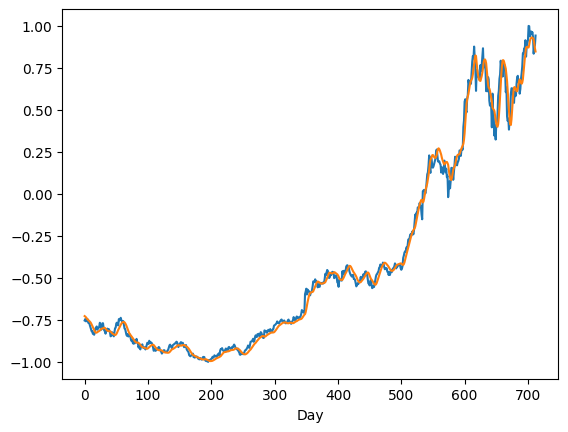

In [181]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label = 'Actual Close')
plt.plot(predicted, label = 'Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()